In [2]:
import logging
import atlite
logging.basicConfig(level=logging.INFO)

import io
import os
import pathlib

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xarray as xr
from atlite.gis import ExclusionContainer, shape_availability
from shapely.geometry import Polygon
import rasterio
import rioxarray

In [3]:
WDPA_Ia = rasterio.open('WDPA_Ia_100.tiff')
WDPA_Ib = rasterio.open('WDPA_Ib_100.tiff')
WDPA_II = rasterio.open('WDPA_II_100.tiff')
WDPA_III = rasterio.open('WDPA_III_100.tiff')
WDPA_IV = rasterio.open('WDPA_IV_100.tiff')

In [4]:
onshore_turbine = "Vestas_V112_3MW"     # This is recommended for off-shore use
offshore_bottom_turbine = "oedb:V164"
offshore_floating_turbine = "oedb:V164"

In [5]:
heightshp = gpd.read_file('2000m.shp.zip')
degreeshp = gpd.read_file('15degrees.shp.zip')


In [6]:
aggregated_regions = [
    # "AT",
    # "DE",
    # "BE",
    # "BG",
    # "CH",
    # "CZ",
    # "DE",
    "DK",
    # "EE",
    # "ES",
    # "FI",
    # "FR",
    # "UK",
    # "GR",
    # "HR",
    # "HU",
    # "IE",
    # "IT",
    # "LT",
    # "LU",
    # "LV",
    # "NL",
    "NO",
    # "PL",
    # "PT",
    # "RO",
    # "SE",
    # "SI",
    # "SK",
]
pd.DataFrame(aggregated_regions).rename(columns={0: "zone"}).to_csv(
    "zones.csv", index=None
)
desired_regions = aggregated_regions

In [7]:
codes = (
    2,
    4,
    5,
    6,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
)


In [8]:
wind_onshore_codes_no_buffer = (
    3,
    4,
    5,
    7,
    8,
    9,
    10,
    11,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
)

wind_onshore_codes_buffer = {1: 2000, 2: 1000, 6: 5000}

In [ ]:
nuts_to_ssb = {
    "NO081": "NO03",
    "NO082": "NO30",
    "NO020": "NO34",
    "NO091": "NO38",
    "NO092": "NO42",
    "NO0A1": "NO11",
    "NO0A2": "NO46",
    "NO0A3": "NO15",
    "NO060": "NO50",
    "NO071": "NO18",
    "NO074": "NO54",
}

In [9]:
# The year for which to calculate the weather data:
year = 2010
euroshape = gpd.read_file("NUTS_RG_60M_2021_4326.geojson")
eurooffshoreshape = gpd.read_file("BOTTOM_MOUNTED_EUROPE_NUTS0" "_NORWAY_NUTS3.geojson")
# Geodata files to use for selecting country onshore and offshore area:
geodata_files = {
    "onshore": euroshape,
    "offshore_bottom": eurooffshoreshape,
}
# The square outer boundaries of Europe to consider,
# because we have downloaded ERA5 for this extent:
rectx1 = -12
rectx2 = 44
recty1 = 33
recty2 = 81

In [10]:
weatherdata = f"europe_{str(year)}.nc"
CORINE = rasterio.open('corine.tif')

In [11]:
panel = "CSi"
orientation = "latitude_optimal"
file_name = geodata_files["onshore"]

In [11]:
atlite.__version__ 


'0.2.12'

In [12]:
xr.__version__  # should be 0.18.2

'2023.12.0'

In [ ]:
%psource atlite.Cutout.convert_and_aggregate

In [14]:
desired_regions

['DK', 'NO']

In [15]:
file_name

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DE149,DE149,3,DE,Sigmaringen,Sigmaringen,4.0,3,3,DE149,"POLYGON ((9.34760 48.23950, 9.60490 48.00230, ..."
1,DE211,DE211,3,DE,"Ingolstadt, Kreisfreie Stadt","Ingolstadt, Kreisfreie Stadt",4.0,2,3,DE211,"POLYGON ((11.48930 48.74500, 11.43310 48.69940..."
2,DE212,DE212,3,DE,"München, Kreisfreie Stadt","München, Kreisfreie Stadt",4.0,1,3,DE212,"POLYGON ((11.41250 48.12710, 11.40290 48.20310..."
3,DE213,DE213,3,DE,"Rosenheim, Kreisfreie Stadt","Rosenheim, Kreisfreie Stadt",4.0,2,3,DE213,"POLYGON ((11.99850 47.78840, 12.09680 47.92310..."
4,DE214,DE214,3,DE,Altötting,Altötting,4.0,2,3,DE214,"POLYGON ((12.94470 48.20670, 12.75160 48.11280..."
...,...,...,...,...,...,...,...,...,...,...,...
2005,CZ,CZ,0,CZ,Česko,Česko,0.0,0,0,CZ,"POLYGON ((14.49120 51.04350, 14.61880 50.85780..."
2006,DE,DE,0,DE,Deutschland,Deutschland,0.0,0,0,DE,"MULTIPOLYGON (((9.11310 54.87360, 9.27360 54.8..."
2007,AL032,AL032,3,AL,Fier,Fier,4.0,3,1,AL032,"POLYGON ((19.78170 40.42130, 19.31880 40.64500..."
2008,NO,NO,0,NO,Norge,Norge,0.0,0,0,NO,"MULTIPOLYGON (((28.89670 69.04260, 29.15370 69..."


In [12]:
# Getting the required countries shape polygon coordinates
europe = (file_name.replace({"GB": "UK", "EL": "GR"})
                      .rename(columns={"NUTS_ID": "index"})
                      .loc[:, ["index", "geometry"]]
                      .sort_values("index")
                      .set_index("index")
                      .loc[desired_regions]
                      )
europe

,geometry
index,
DK,"MULTIPOLYGON (((15.16290 55.09370, 15.09400 54..."
NO,"MULTIPOLYGON (((28.89670 69.04260, 29.15370 69..."


<Axes: >

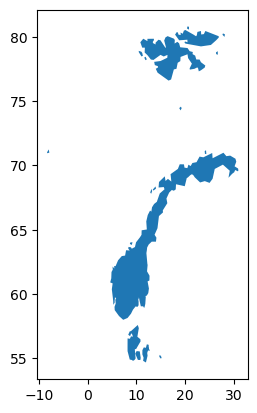

In [17]:
# Extract the Polygon's exterior points for plotting
europe.plot()

In [13]:
polygon = Polygon(
    [
        (rectx1, recty1),
        (rectx1, recty2),
        (rectx2, recty2),
        (rectx2, recty1),
        (rectx1, recty1),
    ]
)

<Axes: >

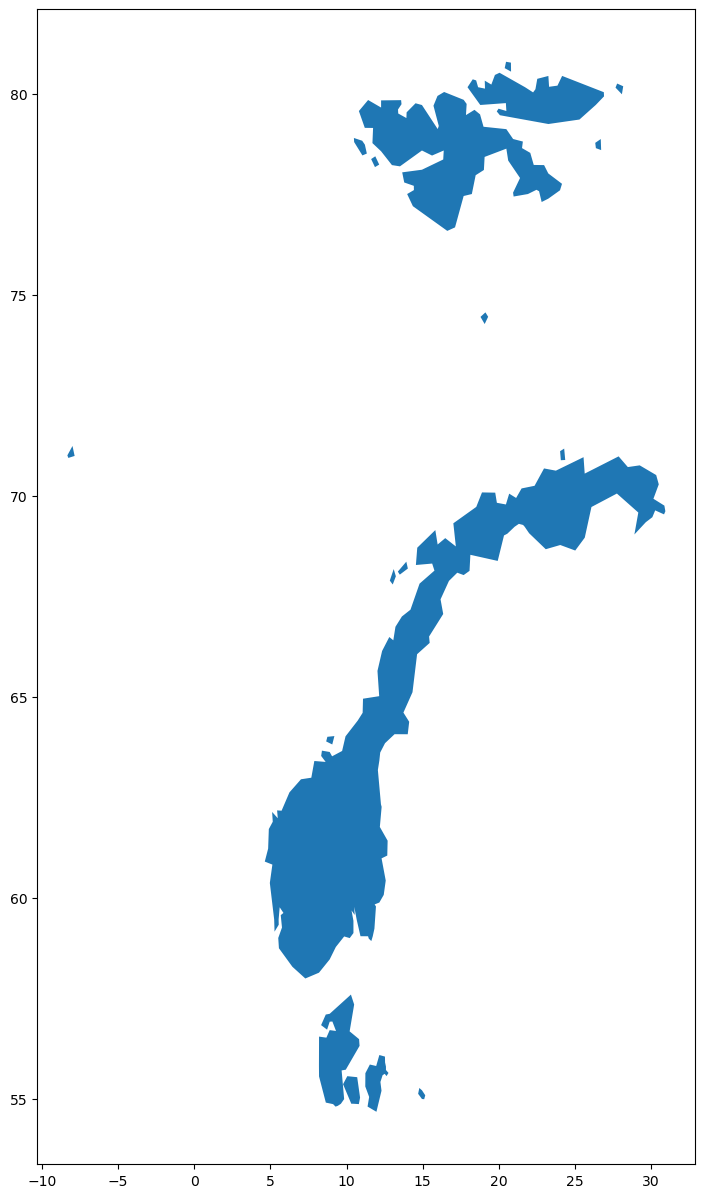

In [14]:
# Clipping the parts out from europe geodata frame that are outside of polygon
europe = gpd.clip(europe, polygon)
europe.plot(figsize=(15, 15))

In [15]:
offshore_to_ISO3166 = {
    "Albania"        : "AL",
    "Belgium"        : "BE",
    "Bulgaria"       : "BG",
    "Croatia"        : "HR",
    "Cyprus"         : "CY",
    "Denmark"        : "DK",
    "Estonia"        : "EE",
    "Finland"        : "FI",
    "France"         : "FR",
    "Germany"        : "DE",
    "Greece"         : "GR",
    "Ireland"        : "IE",
    "Italy"          : "IT",
    "Latvia"         : "LV",
    "Lithuania"      : "LT",
    "Malta"          : "MT",
    "Netherlands"    : "NL",
    "Poland"         : "PL",
    "Portugal"       : "PT",
    "Romania"        : "RO",
    "Spain"          : "ES",
    "Slovenia"       : "SI",
    "Slovakia"       : "SK",
    "Sweden"         : "SE",
    "United Kingdom" : "UK"
}

In [16]:
boundaries = []
for geodata_file_name, geodata_file_path in geodata_files.items():
    print(geodata_file_path)
    boundaries.append(
        geodata_file_path
        .replace(offshore_to_ISO3166)
        .rename(columns={"id": "index"})
        .set_index("index")
        .filter(items=desired_regions,axis=0)
        .bounds
    )

         id NUTS_ID  LEVL_CODE CNTR_CODE                     NAME_LATN  \
0     DE149   DE149          3        DE                   Sigmaringen   
1     DE211   DE211          3        DE  Ingolstadt, Kreisfreie Stadt   
2     DE212   DE212          3        DE     München, Kreisfreie Stadt   
3     DE213   DE213          3        DE   Rosenheim, Kreisfreie Stadt   
4     DE214   DE214          3        DE                     Altötting   
...     ...     ...        ...       ...                           ...   
2005     CZ      CZ          0        CZ                         Česko   
2006     DE      DE          0        DE                   Deutschland   
2007  AL032   AL032          3        AL                          Fier   
2008     NO      NO          0        NO                         Norge   
2009   NO0B    NO0B          2        NO        Jan Mayen and Svalbard   

                         NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0                      Sigmarin

In [97]:
boundaries

[      minx     miny     maxx     maxy
 DK  8.1837  54.6835  15.1629  57.5981
 NO -8.3354  57.9989  30.9297  80.7991,
     minx       miny       maxx       maxy
 DK  3.25  54.364833  16.413266  57.936733]

In [17]:
boundaries = pd.concat(boundaries)

In [100]:
boundaries

,minx,miny,maxx,maxy
DK,8.1837,54.683500,15.162900,57.598100
NO,-8.3354,57.998900,30.929700,80.799100
DK,3.2500,54.364833,16.413266,57.936733


In [18]:
boundaries = boundaries.groupby(lambda x: "bountry").agg(
    {"minx": "min", "miny": "min", "maxx": "max", "maxy": "max"}
)

In [102]:
boundaries

,minx,miny,maxx,maxy
bountry,-8.3354,54.364833,30.9297,80.7991


In [19]:
boundaries["minx"] = boundaries["minx"] - 2
boundaries["miny"] = boundaries["miny"] - 2
boundaries["maxx"] = boundaries["maxx"] + 2
boundaries["maxy"] = boundaries["maxy"] + 2
boundaries

,minx,miny,maxx,maxy
bountry,-10.3354,52.364833,32.9297,82.7991


In [50]:
weatherdata

'europe_2010.nc'

In [20]:
cutout = atlite.Cutout(path=weatherdata)

In [52]:
cutout.prepared_features

module  feature    
gebco   height                   height
era5    wind                    wnd100m
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
dtype: object

In [21]:
cutout.prepare

<bound method cutout_prepare of <Cutout "europe_2010">
 x = -13.00 ⟷ 45.00, dx = 0.25
 y = 32.00 ⟷ 82.00, dy = 0.25
 time = 2010-01-01 ⟷ 2010-12-31, dt = H
 module = ['gebco', 'era5']
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']>

In [22]:
cutout = atlite.Cutout(
    #path="../3_intermediate_data/intermediatecutout.nc",
    path = 'c:/Users/javedm/planets/tiff_file_read/europe_2010.nc',
    data=cutout.data.sel(
        x=slice(
            boundaries.loc["bountry", "minx"],
            boundaries.loc["bountry", "maxx"],
        ),
        y=slice(
            boundaries.loc["bountry", "miny"],
            boundaries.loc["bountry", "maxy"],
        ),
    ),
    time = slice("2010-01", '2010-02'),
)

c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\atlite\cutout.py:190: UserWarning: Arguments data, time are ignored, since cutout is already built.
  warn(


In [55]:
cutout.prepare

<bound method cutout_prepare of <Cutout "europe_2010">
 x = -13.00 ⟷ 45.00, dx = 0.25
 y = 32.00 ⟷ 82.00, dy = 0.25
 time = 2010-01-01 ⟷ 2010-12-31, dt = H
 module = ['gebco', 'era5']
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']>

In [34]:
#cutout.prepare()

In [ ]:
#cutout.wind

In [49]:
#plt.plot(cutout.irradiation(orientation))
print(dir(cutout))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'area', 'availabilitymatrix', 'available_features', 'bounds', 'chunks', 'coefficient_of_performance', 'convert_and_aggregate', 'coords', 'crs', 'csp', 'data', 'dt', 'dx', 'dy', 'extent', 'grid', 'heat_demand', 'hydro', 'indicatormatrix', 'intersectionmatrix', 'irradiation', 'layout_from_capacity_list', 'line_rating', 'merge', 'meta', 'module', 'name', 'path', 'prepare', 'prepared', 'prepared_features', 'pv', 'runoff', 'sel', 'shape', 'soil_temperature', 'solar_thermal', 'temperature', 'to_file', 'transform', 'transform_r', 'uniform_density_layout', 'uniform_layout', 'wind']


In [23]:
spatials = [
    # "grid",
    "region"
]

In [24]:
#Function to assign a unique identifier to each grid cell taking each row as x each time
gridcellnamingfunction = (
    lambda x: "x"
    + (x.x * 100).astype("int").astype("str")
    + "y"
    + (x.y * 100).astype("int").astype("str")
)

In [25]:
if spatials == ["grid"]:
    (
        cutout.grid.assign(gridcell=gridcellnamingfunction)
        .loc[:, ["gridcell"]]
        .to_csv("indreg", header=False, index=False)        
    )
else:
    with open("inderg", "w"):
        pass



In [26]:
excluder_solar = ExclusionContainer()

In [27]:
excluder_solar.add_raster(CORINE, codes=codes)

In [28]:
excluder_solar.add_raster(WDPA_Ia)
excluder_solar.add_raster(WDPA_Ib)
excluder_solar.add_raster(WDPA_II)
excluder_solar.add_raster(WDPA_III)
excluder_solar.add_raster(WDPA_IV)

In [29]:
excluder_solar

Exclusion Container
 registered rasters: 6 
 registered geometry collections: 0
 CRS: 3035 - Resolution: 100

In [30]:
# converting degreeshape CRS to excluder_solar CRS
slope = degreeshp.to_crs(excluder_solar.crs)
slope = slope[slope["gridcode"] == 1]
slope

#Excluding everything else except required (which are areas with gridcode == one)
excluder_solar.add_geometry(slope.geometry, invert=True)

In [31]:
height = heightshp.to_crs(excluder_solar.crs)
height = height[height["gridcode"] == 1]

excluder_solar.add_geometry(height.geometry, invert=True)

In [32]:
cutoff_values = {"solar": 0.09, "onwind": 0.15, "offwind": 0.20}

def cutoff_raster (technology,output):
    if technology == 'pv':
        cf = cutout.pv(panel=panel, orientation=orientation, capacity_factor=True)
        smallestincluded = cutoff_values["solar"]

    if technology == 'onwind':
        cf = cutout.wind(turbine=onshore_turbine, capacity_factor=True)
        smallestincluded = cutoff_values["onwind"]

    if technology == 'offwind':
        cf = cutout.wind(turbine=offshore_bottom_turbine, capacity_factor=True)
        smallestincluded = cutoff_values["offwind"]
    # giving zero to where CF is greater than smallestincluded while one where CF less than smallestincluded
    excluded = cf.where(cf.values>=smallestincluded, other=1)
    excluded = excluded.where(cf.values<smallestincluded, other=0)
    cf_exclusion = excluded.rio.write_crs(europe.crs)
    cf_exclusion.rio.to_raster(output)


In [33]:
low_cf = "cf_excluder_soalr.tiff"
if spatials == ['region'] and cutoff_values["solar"] != 0:
    cutoff_raster('pv', low_cf)
    excluder_solar.add_raster(low_cf)



INFO:atlite.convert:Convert and aggregate 'pv'.


[########################################] | 100% Completed | 12m 19s


In [158]:
availability_matrix_solar = cutout.availabilitymatrix(europe, excluder_solar)

Compute availability matrix: 100%|██████████| 2/2 [01:14<00:00, 37.24s/ gridcells]


<Axes: title={'center': 'index = NO'}, xlabel='x', ylabel='y'>

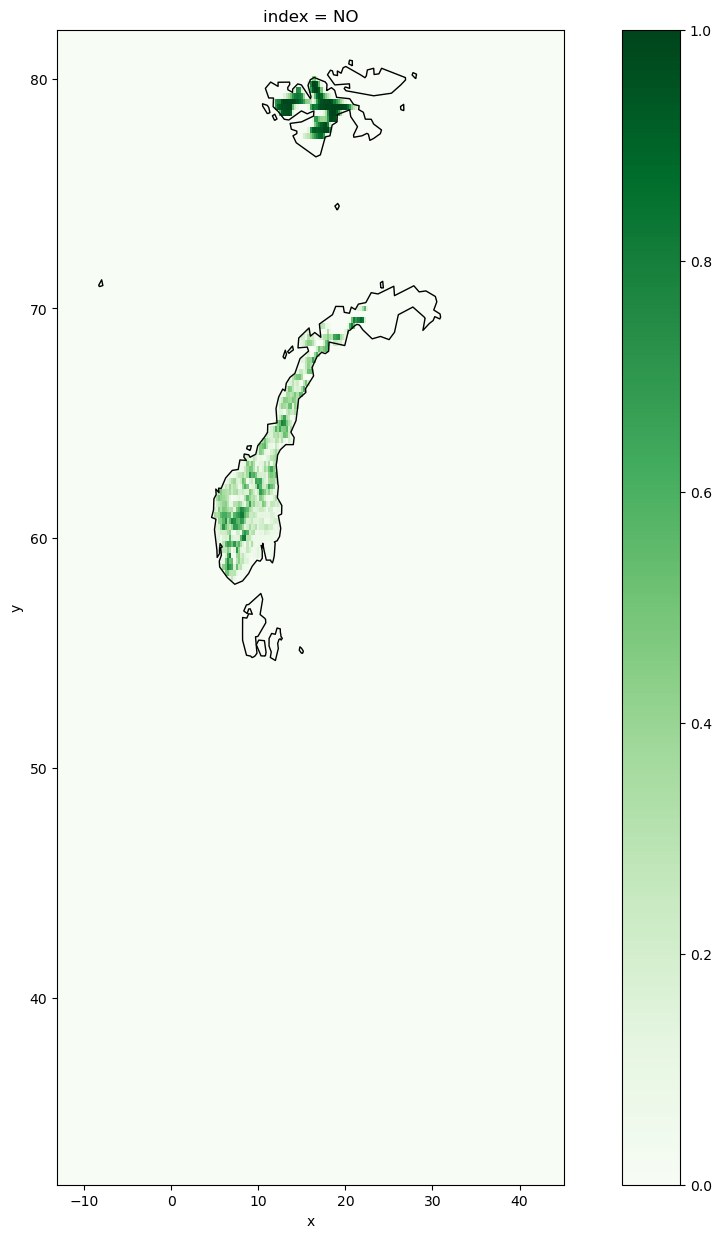

In [37]:
fig, ax = plt.subplots(figsize=(15, 15))
availability_matrix_solar.sel(index="NO").plot(cmap="Greens")
europe.plot(ax=ax, edgecolor="k", color="None")
#cutout.grid.plot(ax=ax, color="None", edgecolor="grey", ls=":")

In [200]:
area = cutout.grid.set_index(["x", "y"]).to_crs(3035).area / 1e6

area = xr.DataArray(area, dims=("spatial"))

capacity_matrix_solar = (
    availability_matrix_solar.stack(spatial=["x", "y"]) * area
)

#capacity_matrix_solar = capacity_matrix_solar.reindex(
#    spatial=area.indexes.get("spatial")
#)

# Create a new DataArray with updated dimensions and coordinates
capacity_matrix_solar = xr.DataArray(
    capacity_matrix_solar,
    dims=['index', 'spatial'],
    coords={
        'index': capacity_matrix_solar.index,
        'spatial': area.coords['spatial']
    }
)

capacity_matrix_solar

<xarray.DataArray (index: 2, spatial: 46833)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * index    (index) object 'DK' 'NO'
  * spatial  (spatial) object MultiIndex
  * x        (spatial) float64 -13.0 -12.75 -12.5 -12.25 ... 44.5 44.75 45.0
  * y        (spatial) float64 32.0 32.0 32.0 32.0 32.0 ... 82.0 82.0 82.0 82.0

In [206]:
if spatials == ["grid"]:
    highRESareasSolar = (
        capacity_matrix_solar.unstack()
        .stack(spatial = ["index", "x", "y"])
        .to_pandas()
        .reset_index()
        .replace({"index": nuts_to_ssb})
        .assign(
            gridcell = gridcellnamingfunction,
            new_index = lambda x: "solar." + x["index"]+ "."+x["gridcell"],
        )
        .set_index("new_index")
        .drop(columns=["index"])
        .loc[:, [0]]
        .rename(columns={0:"area"})
        .query("area != 0")
    )


In [238]:
if spatials == ["region"]:
    highRESareasSolar = (
        capacity_matrix_solar.sum("spatial")
        .to_pandas()
        .reset_index()
        .assign(
            new_idx=lambda x: "Solar." + x["index"] + "." + x["index"],
        )
        .set_index("new_idx")
        .drop(columns=["index"])
        .loc[:, [0]]
        .rename(columns={0: "area"})
        .query("area != 0")
    )
highRESareasSolar

,area
new_idx,
Solar.DK.DK,1741.888622
Solar.NO.NO,91069.412216


In [240]:
(
    highRESareasSolar.round(1).to_csv(
        "areassolar.csv", header=False, sep=" "
    )
)

In [241]:
if spatials == ["grid"]:
    _, capacity_factor_solar = cutout.pv(
        panel=panel,
        orientation=orientation,
        capacity_factor=True,
    )
if spatials == ["region"]:
    capacity_factor_solar = cutout.pv(
        panel=panel,
        orientation=orientation,
        matrix=capacity_matrix_solar,
        per_unit=True,
        capacity_factor=True,
        index=capacity_matrix_solar.index,
    )

capacity_factor_solar

INFO:atlite.convert:Convert and aggregate 'pv'.


[########################################] | 100% Completed | 564.45 s


<xarray.DataArray (time: 8760, index: 2)>
array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
  * index    (index) object 'DK' 'NO'
Attributes:
    units:    p.u.

In [242]:
# Starting for Wind
Excluder_wind_onshore = ExclusionContainer()
wind_onshore_codes_no_buffer

(3, 4, 5, 7, 8, 9, 10, 11, 34, 35, 36, 37, 38, 39, 40, 41)

In [243]:
wind_onshore_codes_buffer

{1: 2000, 2: 1000, 6: 5000}

In [244]:
degreeshp

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,geometry
0,1,1,2,0.065382,0.000150,"POLYGON ((20.60833 80.75000, 20.61340 80.75587..."
1,2,2,2,0.016667,0.000017,"POLYGON ((20.61667 80.74167, 20.61250 80.74167..."
2,3,3,2,0.025000,0.000035,"POLYGON ((20.62917 80.73750, 20.62083 80.73750..."
3,4,4,2,0.040492,0.000047,"POLYGON ((20.63750 80.73333, 20.62917 80.73333..."
4,5,5,1,0.033333,0.000052,"POLYGON ((20.92917 80.72083, 20.92917 80.72500..."
...,...,...,...,...,...,...
100632,100633,100633,2,0.015712,0.000012,"POLYGON ((33.06250 34.80833, 33.05742 34.80976..."
100633,100634,100634,2,0.015712,0.000012,"POLYGON ((33.10833 34.80000, 33.10326 34.80143..."
100634,100635,100635,2,0.029589,0.000041,"POLYGON ((33.11250 34.78333, 33.11461 34.79314..."
100635,100636,100636,2,0.015712,0.000012,"POLYGON ((33.11250 34.78333, 33.11107 34.77826..."


In [245]:
slope = degreeshp.to_crs(Excluder_wind_onshore.crs)

slope = slope[slope["gridcode"] == 1]

Excluder_wind_onshore.add_geometry(
    slope.geometry, invert=True
)
#Invert=True, means that keep the geometry that is in slope.geometry

In [246]:
heightshp

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,geometry
0,1,1,1,0.356757,0.005121,"POLYGON ((20.72083 80.70417, 20.67662 80.70640..."
1,2,2,1,0.478709,0.007550,"POLYGON ((21.14583 80.65417, 21.10916 80.65624..."
2,3,3,1,0.191728,0.002041,"POLYGON ((25.05000 80.64167, 24.99462 80.64479..."
3,4,4,1,0.827737,0.013743,"POLYGON ((20.72500 80.61667, 20.70363 80.61965..."
4,5,5,1,0.191061,0.002027,"POLYGON ((19.75417 80.60000, 19.74634 80.60699..."
...,...,...,...,...,...,...
3813,3814,3814,2,0.015712,0.000012,"POLYGON ((25.52500 35.11667, 25.51992 35.11809..."
3814,3815,3815,2,0.044813,0.000092,"POLYGON ((25.47500 35.08333, 25.46489 35.09085..."
3815,3816,3816,1,7.428274,0.813183,"POLYGON ((24.81667 34.92917, 24.76681 34.93129..."
3816,3817,3817,1,0.196314,0.002391,"POLYGON ((24.10833 34.81667, 24.10232 34.81898..."


In [248]:
height = heightshp.to_crs(Excluder_wind_onshore.crs)

height = height[height["gridcode"]==1]

Excluder_wind_onshore.add_geometry(height.geometry, invert=True)

In [249]:
low_cf = "cf_excluder_onwind.tiff"
if spatials == ['region'] and cutoff_values["onwind"] != 0:
    cutoff_raster('onwind', low_cf)
    Excluder_wind_onshore.add_raster(low_cf)


c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\atlite\resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)
INFO:atlite.convert:Convert and aggregate 'wind'.


[########################################] | 100% Completed | 277.14 s


In [250]:
Excluder_wind_onshore

Exclusion Container
 registered rasters: 1 
 registered geometry collections: 2
 CRS: 3035 - Resolution: 100

In [251]:
availability_matrix_wind_onshore = cutout.availabilitymatrix(
    europe, Excluder_wind_onshore
)
availability_matrix_wind_onshore

Compute availability matrix: 100%|██████████| 2/2 [01:11<00:00, 35.55s/ gridcells]


<xarray.DataArray (index: 2, y: 201, x: 233)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * index    (index) object 'DK' 'NO'
  * y        (y) float64 32.0 32.25 32.5 32.75 33.0 ... 81.25 81.5 81.75 82.0
  * x        (x) float64 -13.0 -12.75 -12.5 -12.25 ... 44.25 44.5 44.75 45.0

In [252]:
availability_matrix_wind_onshore.sum()

<xarray.DataArray ()>
array(584.54265008)

In [304]:
area = cutout.grid.set_index(["x", "y"]).to_crs(3035).area / 1e6
#area.index.get_level_values('y')
area = xr.DataArray(area, dims=("spatial"))
capacity_matrix_wind_onshore = (
    availability_matrix_wind_onshore.stack(spatial = ["x", "y"]) * area
)
#capacity_matrix_wind_onshore = capacity_matrix_wind_onshore.reindex(
#    spatial = area.indexes.get("spatial")
#)

# updated code like
capacity_matrix_wind_onshore = capacity_matrix_wind_onshore.reindex_like(area)
capacity_matrix_wind_onshore

<xarray.DataArray (index: 2, spatial: 46833)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * index    (index) object 'DK' 'NO'
  * spatial  (spatial) object MultiIndex
  * x        (spatial) float64 -13.0 -12.75 -12.5 -12.25 ... 44.5 44.75 45.0
  * y        (spatial) float64 32.0 32.0 32.0 32.0 32.0 ... 82.0 82.0 82.0 82.0

In [305]:
if spatials == ["grid"]:
    highRESareasWindOnshore = (
        capacity_matrix_wind_onshore.unstack()
        .stack(spatial = ["index", "x", "y"])
        .to_pandas()
        .reset_index()
        .assign(
            gridcell=gridcellnamingfunction,
            new_idx = lambda x: "windonshore." + x["index"] + "." + x["gridcell"],
        )
        .set_index("new_idx")
        .drop(columns="index")
        .loc[:, [0]]
        .rename(columns={0: "area"})
        .query("area != 0")
    )


In [307]:
if spatials == ["region"]:
    highRESareasWindOnshore = (
        capacity_matrix_wind_onshore.sum("spatial")
        .to_pandas()
        .reset_index()
        .assign(
            new_idx = lambda x: "Windonshore." + x["index"] + "." + x["index"],
        )
        .set_index("new_idx")
        .drop(columns=["index"])
        .loc[:, [0]]
        .rename(columns={0: "area"})
        .query("area != 0")
    )


In [308]:
highRESareasWindOnshore

,area
new_idx,
Windonshore.DK.DK,34985.112798
Windonshore.NO.NO,124520.102191


In [311]:
(
    highRESareasWindOnshore.round(1).to_csv("areaswindonshore.csv", header=False, sep=" ")

)

In [312]:
onshore_turbine

'Vestas_V112_3MW'

In [313]:
if spatials == ["grid"]:
    _, capacity_factor_wind_onshore = cutout.wind(
        turbine=onshore_turbine, capacity_factor=True
    )
if spatials == ["region"]:
    capacity_factor_wind_onshore = cutout.wind(
        turbine=onshore_turbine,
        matrix=capacity_matrix_wind_onshore,
        per_unit = True,
        capacity_factor = True,
        index = capacity_matrix_wind_onshore.index,

    )

c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\atlite\resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)
INFO:atlite.convert:Convert and aggregate 'wind'.


[########################################] | 100% Completed | 172.65 s


In [314]:
capacity_factor_wind_onshore

<xarray.DataArray (time: 8760, index: 2)>
array([[0.16852069, 0.07684564],
       [0.14280322, 0.08762079],
       [0.12988901, 0.09731986],
       ...,
       [0.9999903 , 0.53538059],
       [1.        , 0.56571729],
       [1.        , 0.54931421]])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
  * index    (index) object 'DK' 'NO'
Attributes:
    units:    p.u.

In [315]:
#Offshore bottom calculation started

geodata_files["offshore_bottom"]

,index,OBJECTID_1,type,Shape_Leng,NUTS_ID,Shape_Le_1,Shape_Area,geometry
0,Albania,1,3,1.132852,None,1.132852,0.014745,"MULTIPOLYGON (((19.78292 39.93611, 19.78218 39..."
1,Belgium,2,3,2.609452,None,2.609452,0.353314,"POLYGON ((3.27669 51.45813, 3.26904 51.45617, ..."
2,Bulgaria,3,3,8.398102,None,8.398102,0.374147,"MULTIPOLYGON (((28.19857 42.10508, 28.20000 42..."
3,Croatia,4,3,11.312996,None,11.312996,0.960277,"MULTIPOLYGON (((16.03750 42.55833, 16.02500 42..."
4,Cyprus,5,3,0.137151,None,0.137151,0.000646,"POLYGON ((34.86618 35.87644, 34.85000 35.85833..."
5,Denmark,6,3,52.568125,None,52.568125,9.260703,"MULTIPOLYGON (((15.38306 54.73795, 15.38750 54..."
6,Estonia,7,3,27.187247,None,27.187247,1.533806,"MULTIPOLYGON (((20.57670 58.06080, 20.57500 58..."
7,Finland,8,3,69.997692,None,69.997692,3.661957,"MULTIPOLYGON (((20.85274 59.33008, 20.85417 59..."
8,France,9,3,61.910059,None,61.910059,4.018784,"MULTIPOLYGON (((8.76913 41.28580, 8.77083 41.2..."
9,Germany,10,3,35.146275,None,35.146275,5.631322,"MULTIPOLYGON (((11.96667 52.87500, 11.96912 52..."


In [319]:
europe_offshore_bottom = (
    geodata_files["offshore_bottom"]
    .replace(offshore_to_ISO3166)
    .set_index("index")
    .filter(items=desired_regions, axis=0)
)
europe_offshore_bottom

,OBJECTID_1,type,Shape_Leng,NUTS_ID,Shape_Le_1,Shape_Area,geometry
DK,6,3,52.568125,None,52.568125,9.260703,"MULTIPOLYGON (((15.38306 54.73795, 15.38750 54..."


<Axes: >

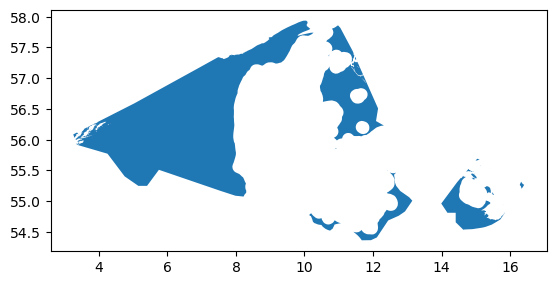

In [320]:
europe_offshore_bottom.plot()

In [323]:
europe_offshore_bottom = gpd.clip(europe_offshore_bottom, polygon)

<Axes: >

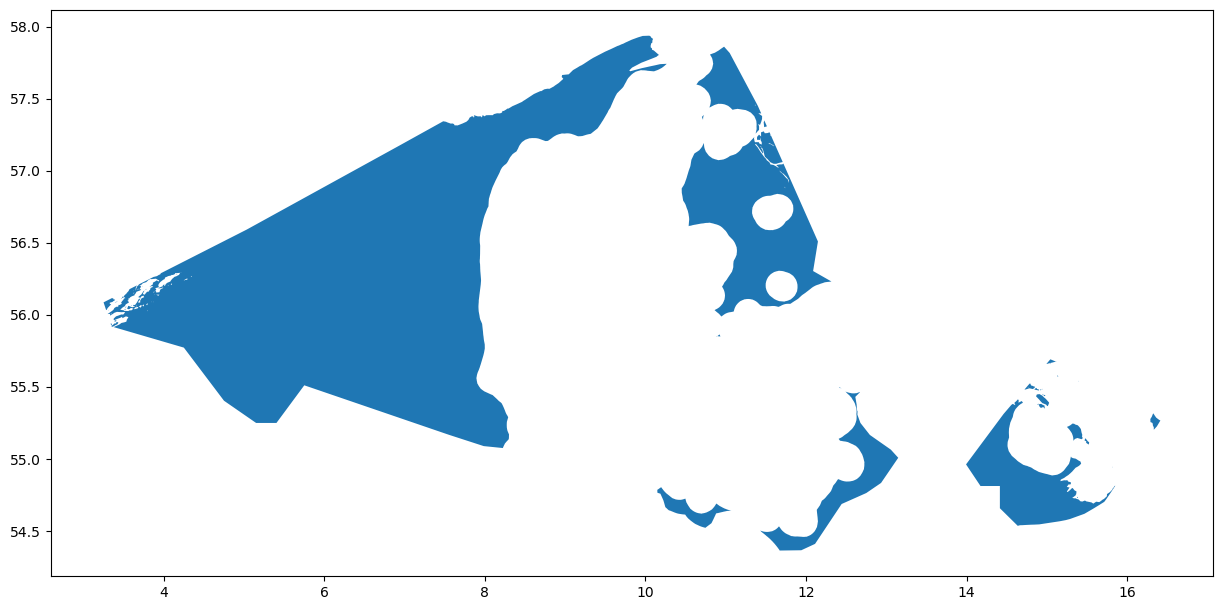

In [324]:
europe_offshore_bottom.plot(figsize=(15, 15))

In [325]:
Excluder_wind_offshore_bottom = ExclusionContainer()

In [326]:
Excluder_wind_offshore_bottom

Exclusion Container
 registered rasters: 0 
 registered geometry collections: 0
 CRS: 3035 - Resolution: 100

In [327]:
Excluder_wind_offshore_bottom.add_raster(WDPA_Ia)
Excluder_wind_offshore_bottom.add_raster(WDPA_Ib)
Excluder_wind_offshore_bottom.add_raster(WDPA_II)
Excluder_wind_offshore_bottom.add_raster(WDPA_III)
Excluder_wind_offshore_bottom.add_raster(WDPA_IV)

In [328]:
low_cf = "cf_excluder_windoff.tiff"
if spatials == ["region"] and cutoff_values ["offwind"] != 0:
    cutoff_raster("offwind",low_cf)
    Excluder_wind_offshore_bottom.add_raster(low_cf)

c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\atlite\resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)
INFO:atlite.resource:Searching turbine power curve in OEDB database using .
highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.
INFO:atlite.convert:Convert and aggregate 'wind'.


[########################################] | 100% Completed | 175.27 s


In [331]:
availability_matrix_wind_offshore_bottom = cutout.availabilitymatrix(
    europe_offshore_bottom, Excluder_wind_offshore_bottom
)

Compute availability matrix: 100%|██████████| 1/1 [00:03<00:00,  3.72s/ gridcells]


In [346]:
area = cutout.grid.set_index(["x", "y"]).to_crs(3035).area / 1e6
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix_wind_offshore_bottom = (
    availability_matrix_wind_offshore_bottom.stack(spatial=["x", "y"])*area
)
#capacity_matrix_wind_offshore_bottom = capacity_matrix_wind_offshore_bottom.reindex(
#    spatial = area.indexes.get("spatial"))
capacity_matrix_wind_offshore_bottom = capacity_matrix_wind_offshore_bottom.reindex_like(area)

capacity_matrix_wind_offshore_bottom


<xarray.DataArray (dim_0: 1, spatial: 46833)>
array([[0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * dim_0    (dim_0) object 'DK'
  * spatial  (spatial) object MultiIndex
  * x        (spatial) float64 -13.0 -12.75 -12.5 -12.25 ... 44.5 44.75 45.0
  * y        (spatial) float64 32.0 32.0 32.0 32.0 32.0 ... 82.0 82.0 82.0 82.0

In [348]:
if spatials == ["grids"]:
    highRESareasWindOffshoreBottom = (
        capacity_matrix_wind_offshore_bottom.unstack()
        .stack(spatial = ["index", "x", "y"])
        .to_pandas()
        .reset_index()
        .assign(
            gridcell = gridcellnamingfunction,
            new_idx = lambda x: "windoffshore." + x["dim_0"] + "." + x["dim_0"],
        )
        .set_index("new_idx")
        .drop(columns=["dim_0"])
        .loc[:, [0]]
        .rename(columns={0: "area"})
        .query("area != 0")
    )

if spatials == ["region"]:
    highRESareasWindOffshoreBottom = (
        capacity_matrix_wind_offshore_bottom.sum("spatial")
        .to_pandas()
        .reset_index()
        .assign(
            new_idx=lambda x: "Windoffshore." + x["dim_0"]+ "." + x["dim_0"],
        )
        .set_index("new_idx")
        .drop(columns=["dim_0"])
        .loc[:, [0]]
        .rename(columns={0: "area"})
        .query("area != 0")
    )
highRESareasWindOffshoreBottom

,area
new_idx,
Windoffshore.DK.DK,54685.236567


In [350]:
highRESareasWindOffshoreBottom.round(1).to_csv("areaswindoffshore.csv", header=False, sep=" ")


In [351]:
offshore_bottom_turbine

'oedb:V164'

In [353]:
if spatials == ["grid"]:
    _, capacity_factor_wind_offshore_bottom = cutout.wind(
        turbine=offshore_bottom_turbine, capacity_factor=True
    )

if spatials == ["region"]:
    capacity_factor_wind_offshore_bottom = cutout.wind(
        turbine=offshore_bottom_turbine,
        matrix=capacity_matrix_wind_offshore_bottom,
        per_unit=True,
        capacity_factor=True,
        index=capacity_matrix_wind_offshore_bottom.dim_0,
    )

c:\Users\javedm\AppData\Local\miniconda3\envs\atlite\Lib\site-packages\atlite\resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.13.
  warnings.warn(msg, FutureWarning)
INFO:atlite.resource:Searching turbine power curve in OEDB database using .
highest wind speed is not zero. You can either change the power curve manually or set
'add_cutout_windspeed=True' in the Cutout.wind conversion method.
INFO:atlite.convert:Convert and aggregate 'wind'.


[########################################] | 100% Completed | 195.74 s


In [375]:
capacity_factor_wind_offshore_bottom = capacity_factor_wind_offshore_bottom.rename({'dim_0': 'index'})

In [376]:
capacity_factor_solar.name = None
capacity_factor_wind_onshore.name = None

In [377]:
capacity_factor_solar.name = "Solar"
capacity_factor_wind_onshore.name = "Windonshore"
capacity_factor_wind_offshore_bottom.name = "Windoffshore"

In [378]:
concatlist = [
    capacity_factor_solar,
    capacity_factor_wind_onshore,
    capacity_factor_wind_offshore_bottom,
]

In [380]:
concatlist

[<xarray.DataArray 'Solar' (time: 8760, index: 2)>
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])
 Coordinates:
   * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
   * index    (index) object 'DK' 'NO'
 Attributes:
     units:    p.u.,
 <xarray.DataArray 'Windonshore' (time: 8760, index: 2)>
 array([[0.16852069, 0.07684564],
        [0.14280322, 0.08762079],
        [0.12988901, 0.09731986],
        ...,
        [0.9999903 , 0.53538059],
        [1.        , 0.56571729],
        [1.        , 0.54931421]])
 Coordinates:
   * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
   * index    (index) object 'DK' 'NO'
 Attributes:
     units:    p.u.,
 <xarray.DataArray 'Windoffshore' (time: 8760, index: 1)>
 array([[0.27601095],
        [0.24644351],
        [0.23342651],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]])
 Coordinates:
   * time     (tim

In [381]:
for i in concatlist:
    print(i.name)

Solar
Windonshore
Windoffshore


In [382]:
range(0, len(capacity_factor_solar.time))

range(0, 8760)

In [388]:
xr.concat(concatlist, pd.Index(list(da.name for da in concatlist), name="technology")).assign_coords(time=range(0, len(concatlist[0].time)))

<xarray.DataArray 'Solar' (technology: 3, time: 8760, index: 2)>
array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.16852069, 0.07684564],
        [0.14280322, 0.08762079],
        [0.12988901, 0.09731986],
        ...,
        [0.9999903 , 0.53538059],
        [1.        , 0.56571729],
        [1.        , 0.54931421]],

       [[0.27601095,        nan],
        [0.24644351,        nan],
        [0.23342651,        nan],
        ...,
        [1.        ,        nan],
        [1.        ,        nan],
        [1.        ,        nan]]])
Coordinates:
  * index       (index) object 'DK' 'NO'
  * technology  (technology) object 'Solar' 'Windonshore' 'Windoffshore'
  * time        (time) int32 0 1 2 3 4 5 6 ... 8754 8755 8756 8757 8758 8759
Attributes:
    units:    p.u.

In [384]:
gridcellnamingfunctionxr = (
    lambda da: "x"
    + (da.x * 100).astype("int").astype("str").astype("object")
    + "y"
    + (da.y * 100).astype("int").astype("str").astype("object")
)

In [387]:
len(concatlist[1].index)

2

In [389]:
if spatials == ["grid"]:
    (
        xr.concat(
            concatlist, pd.Index(list(da.name for da in concatlist), name="technology")
        )
        .stack(spatial=["x", "y"])
        .assign_coords(gridcell=gridcellnamingfunctionxr)
        .set_index(spatial="gridcell")
        .drop_vars(["lat", "lon"])
        .assign_coords(time=range(0, len(concatlist[0].time)))
        .stack(final=["time", "technology", "spatial"])
        .round(2)
        .to_pandas()
        .to_csv("capfacfile")
    )

if spatials == ["region"]:
    (
        xr.concat(
            concatlist, pd.Index(list(da.name for da in concatlist), name="technology")
        )
        .assign_coords(time=range(0, len(concatlist[0].time)))
        .rename({"index": "spatial"})
        .stack(final=["time", "technology", "spatial"])
        .round(2)
        .to_pandas()
        .to_frame()
        .reset_index()
        .fillna(0)
        .set_index(["time", "technology", "spatial"])
        .to_csv("capfacfile")
    )